In [15]:
import scipy.signal
from scipy.stats import linregress
import numpy as np
import os
from sympy.solvers.solveset import solveset
import spectral.io.envi as envi
from importlib import reload
import pandas as pd
import math
from sympy import Symbol
from spectral import imshow
import matplotlib.pyplot as plt
from spectral import *
import seaborn as sns
import warnings
import csv
warnings.filterwarnings('ignore')


In [16]:
class HSI:

    #reading files
    def read_bil(file):
        hdr = file+'.hdr'
        data_ref = envi.open(hdr,file)
        data_nparr = np.array(data_ref.load())
        return data_nparr


    #Defining the region of interest
    def extract_roi(arr, x, y, w, h, intensity, line):
        roi = arr[y:y+h, x:x+w, :]

        bounding_box = arr
        bounding_box[y-line:y, x-line:x+w+line, :] = intensity 
        bounding_box[y:y+h, x-line:x, :] = intensity 
        bounding_box[y+h:y+h+line, x-line:x+w+line, :] = intensity
        bounding_box[y:y+h, x+w:x+w+line, :] = intensity

        return (roi, bounding_box)



    #finding mean spectrum in ROI
    def regions(coordinates,arr,length,intensity,line):
        rois = []
        for coordinate in coordinates:
            (x, y) = coordinate
            (roi, arr) = HSI.extract_roi(arr, x, y, length, length, intensity, line )
            rois.append(roi)

        
        return rois



    #plotting the spectra of each region
    def plotROI(rois,eV,title):
        #fig2, ax2 = plt.subplots(figsize = (10,7))
        for i in range(len(rois)):
            roi = rois[i]
            intensity = []
            intensity_corrected =[]
            for b in range(roi.shape[2]):
                intensity.append(np.mean(roi[:, :,b]))

            intensity_corrected = [ - math.log(y,10) for y in intensity]

        return intensity_corrected

    #finding spectral fingerprint of a pixel
    def pixel_spectrum(x,y,arr):
        #print(bands)
        pixel_x = x
        pixel_y = y
        pixel = arr[pixel_y, pixel_x,:]
        pixel_abs = - np.log10(pixel)
        pixel_abs = pixel_abs[50:]
        
        return pixel_abs
        
    #calculate exciton width
    def exciton_width(ratio):
            w = (1 - math.sqrt(ratio))/((0.405555*math.sqrt(ratio))+1.3333333)
            return w

    #finding the peak absorabance
    def peaks(pixel_abs,eV):
        x = np.stack((eV[:129],pixel_abs[:129]),1)
        x=x.T
        peaks , _ = scipy.signal.find_peaks(x[1],distance = 300)
        #print(peaks)
        peakabs = x[1][peaks]
        peakindex = np.where(x[1] == peakabs)
        peakenergy =x[0][peakindex[0]]
        #print(peakabs, peakenergy)
        return peakabs,peakenergy


    #finding peak absorbance and wavelength of each pixel in image
    #def pixelpeaks(rois,eV,coordinates):    
    def peakabs(rois,eV,el):
        abslist = []
        evlist =[]
        energyratio=[]
        for i in range(len(rois)):
            roi = rois[i]
            abs = np.zeros((roi.shape[0],roi.shape[1]))
            energy = np.zeros((roi.shape[0],roi.shape[1]))
            ratio = np.zeros((roi.shape[0],roi.shape[1]))
            roi = rois[i]
            for x in range(roi.shape[0]):
                for y in range(roi.shape[1]):
                    spectra = HSI.pixel_spectrum(x,y,roi)
                    ratio[x][y] = spectra[el]/spectra[33]
                    peakabs,peakev = HSI.peaks(spectra,eV)    
                    peakabs[peakabs>10000000] =0
                    peakabs[peakabs>1] = np.mean(peakabs)
                    abs[x][y]=peakabs.max()
                    energy[x][y]=peakev.max()    
            abslist.append(abs)
            evlist.append(energy)
            energyratio.append(ratio)
        return abslist, evlist, energyratio


    #heatmap of peak absorbance and corresponsing and ratio energy in image
    def plotheatmap(abs,eV,energyratio,figtitle, title):
        for i in range(len(abs)):
            fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
            plt.suptitle(figtitle)
            sns.heatmap(abs[i],cmap = "Wistia",yticklabels=False,xticklabels=False, ax = ax1,vmin = 0, vmax = 0.5, cbar = True)
            ax1.set_title("Peak absorbance ")
            sns.heatmap(eV[i],cmap= 'cool',yticklabels=False,xticklabels=False,ax = ax2, vmin =2.0 , vmax =3.3,cbar = True)
            ax2.set_title("Peak Wavelength ")
            sns.heatmap(energyratio[i],cmap= 'YlGnBu',yticklabels=False,xticklabels=False, ax = ax3, vmin = 0, vmax = 1,cbar = True)
            ax3.set_title(title)
            plt.show()


    def savespectra(absspc,filename):
        #convert spectra to numpy 
        spc = np.asarray(absspc)
        np.savetxt('{}.csv'.format(filename),spc, delimiter = ',')

In [17]:
labels = np.genfromtxt("../Data/labels.txt", delimiter=',',dtype=str)
bands = np.genfromtxt("../Data/bands.csv", delimiter=',')
bands = bands[0][20:]
eV = 1239.8/bands
relevant_path = "../image/"
c = os.listdir(relevant_path)
c.sort()

def exciton_width(ratio):
        x = Symbol('x')
        f = math.sqrt(ratio) - ((1-(0.24*x/0.18))/(1+(0.073*x/0.18)))
        print (solveset(f,x))

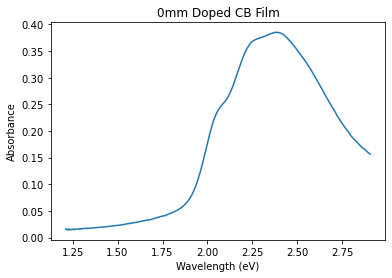

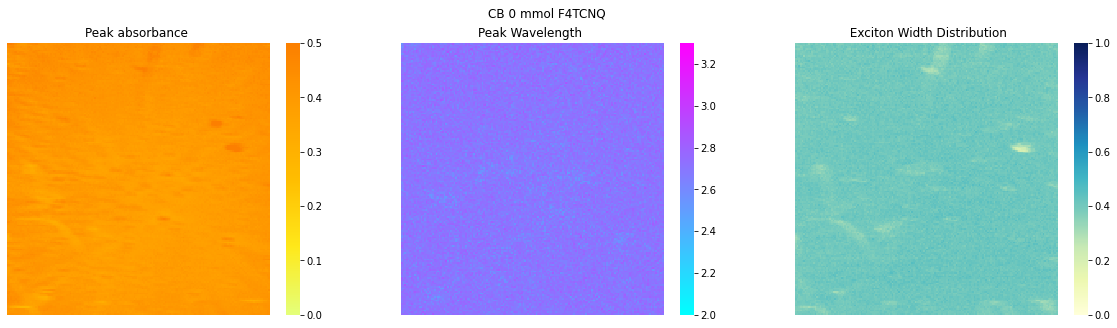

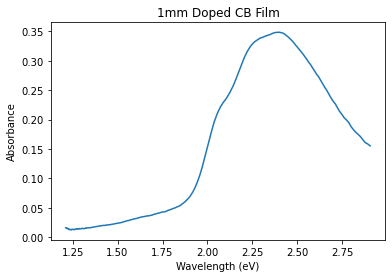

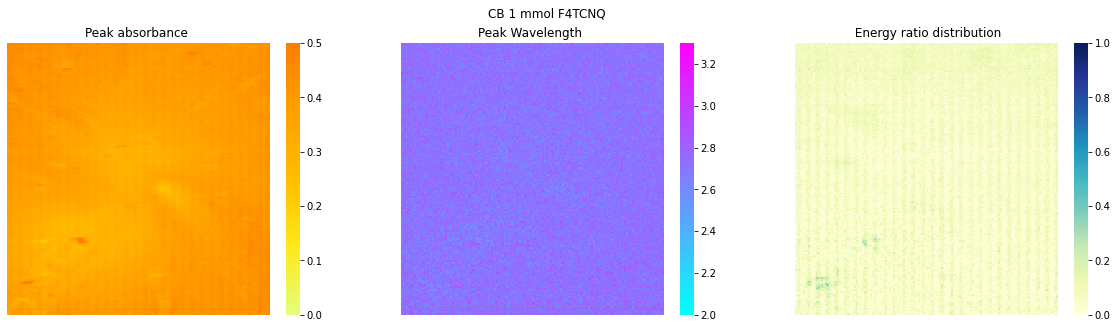

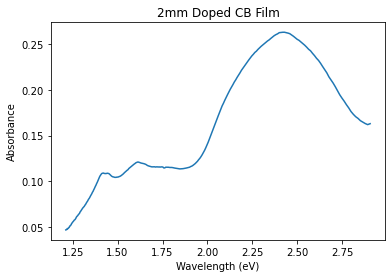

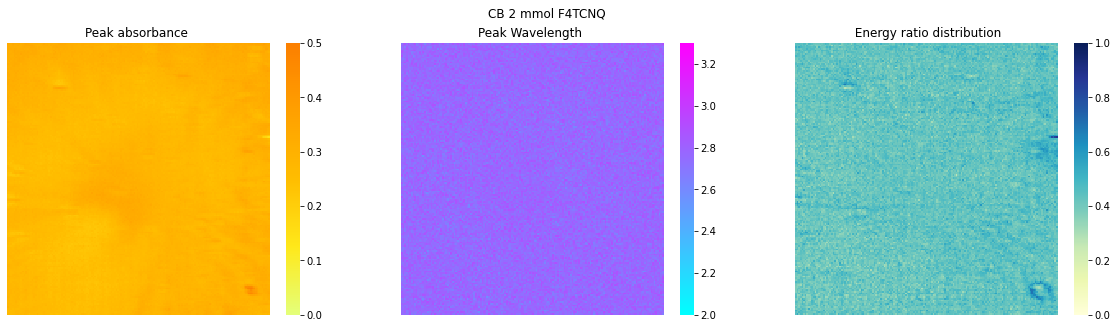

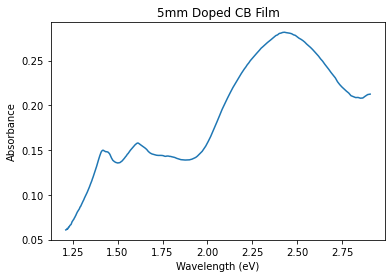

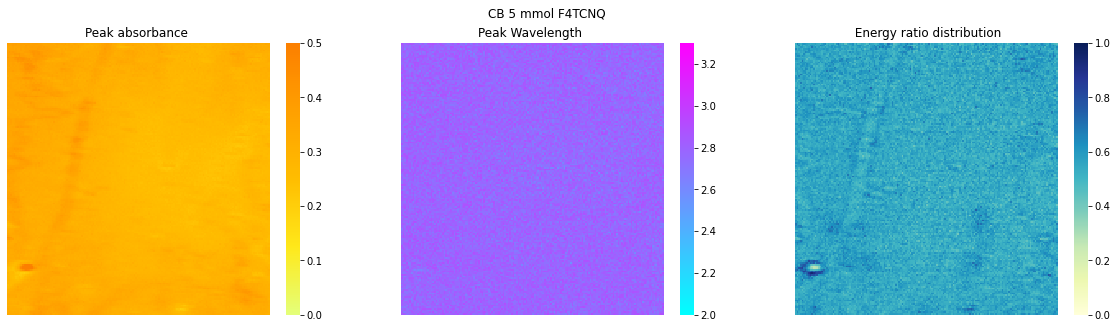

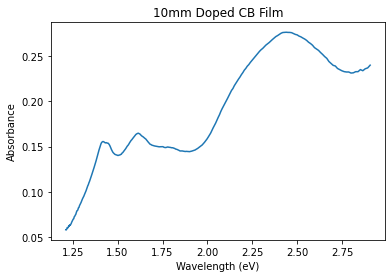

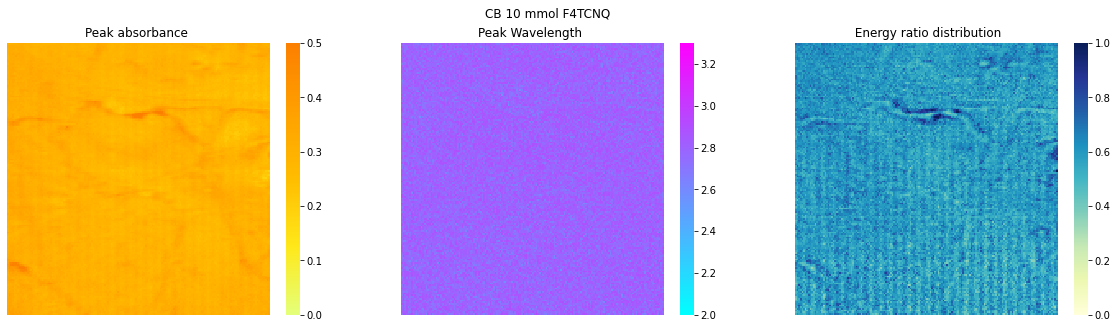

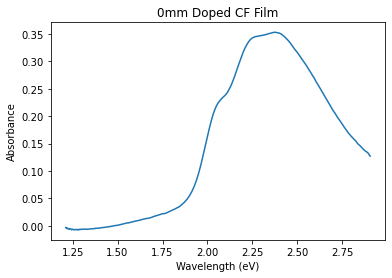

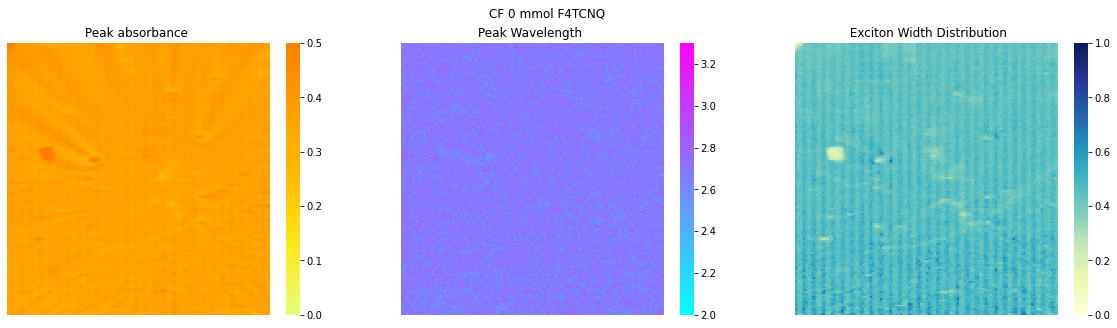

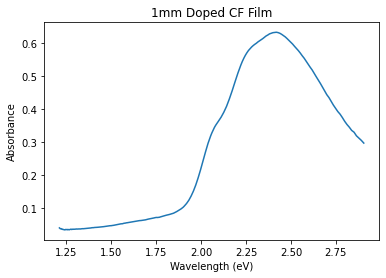

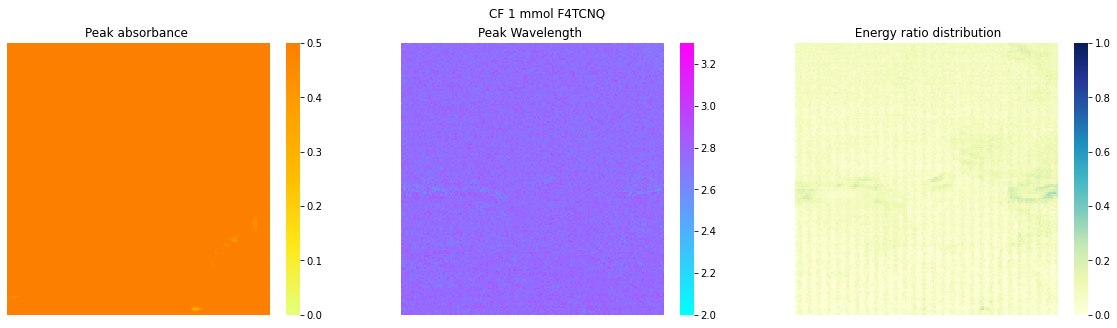

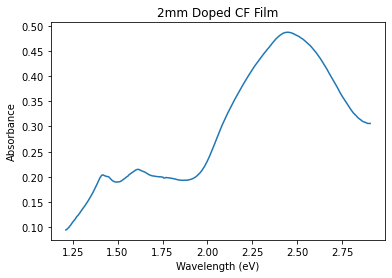

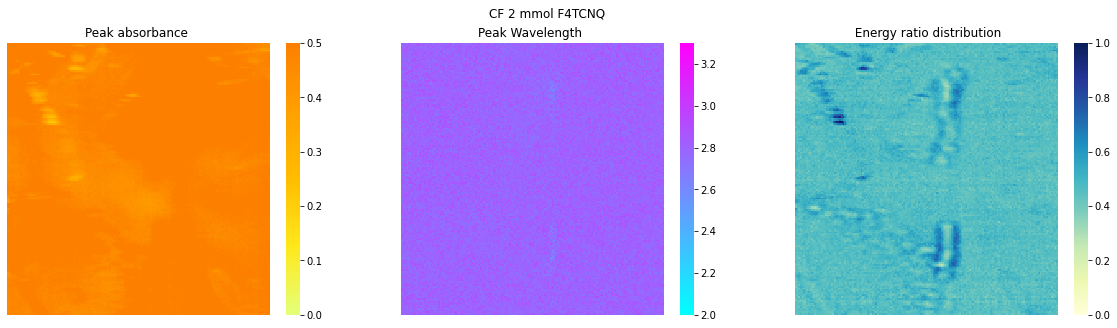

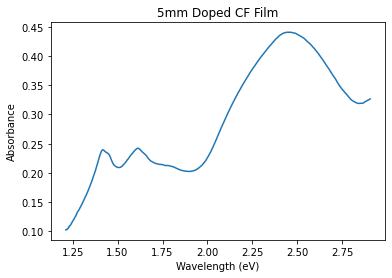

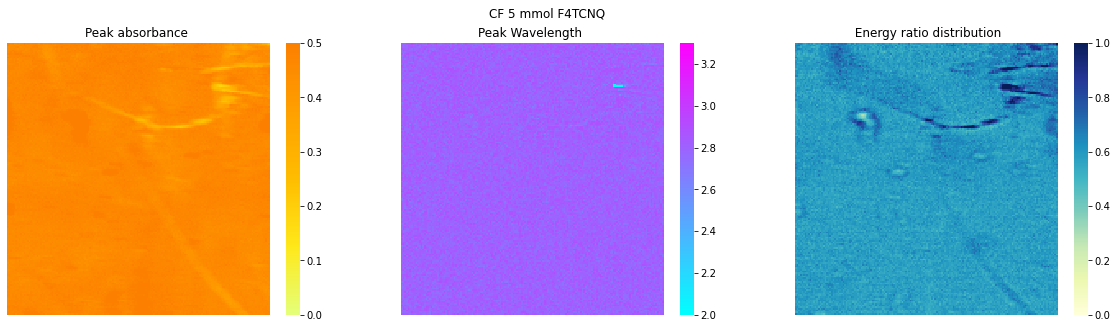

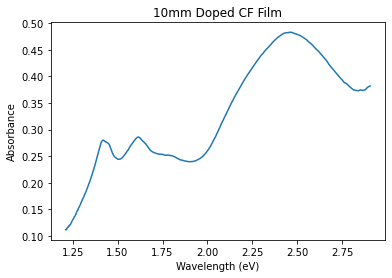

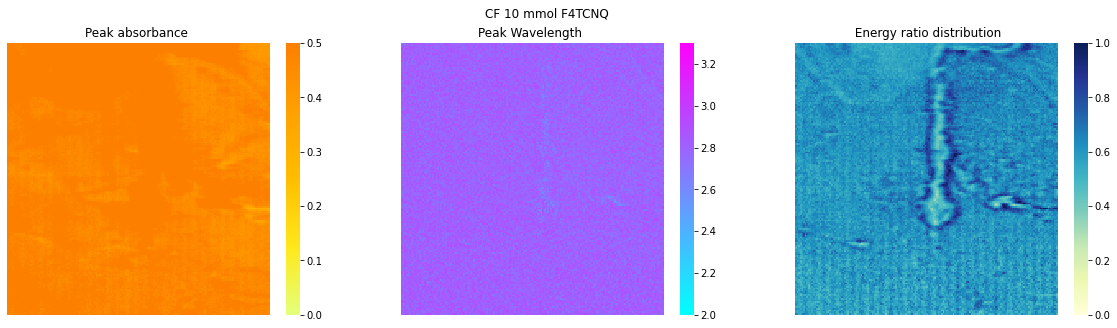

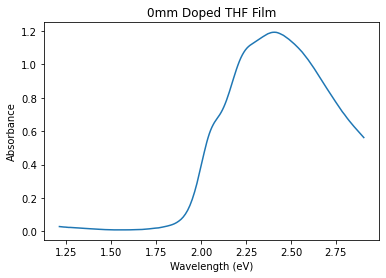

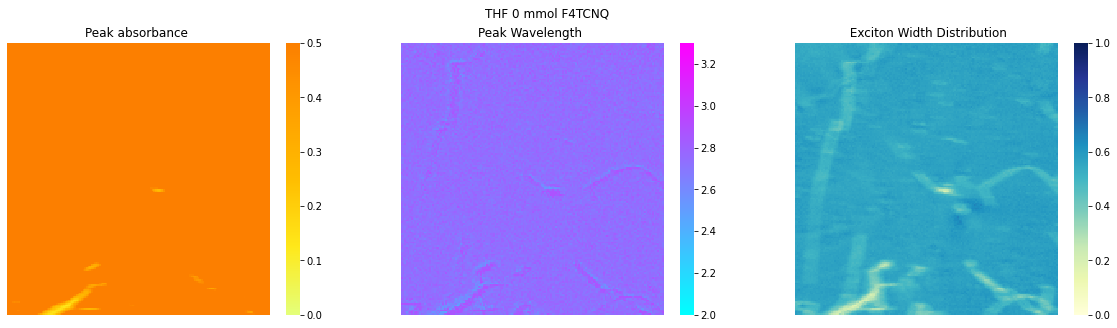

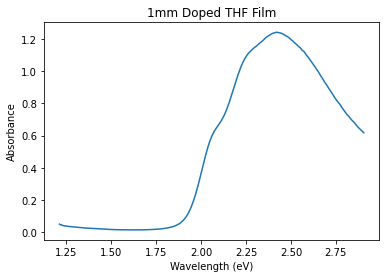

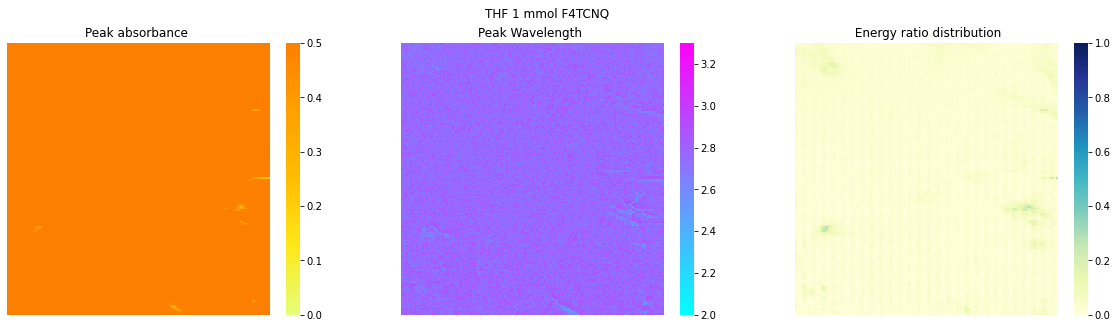

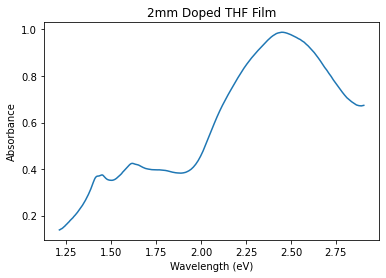

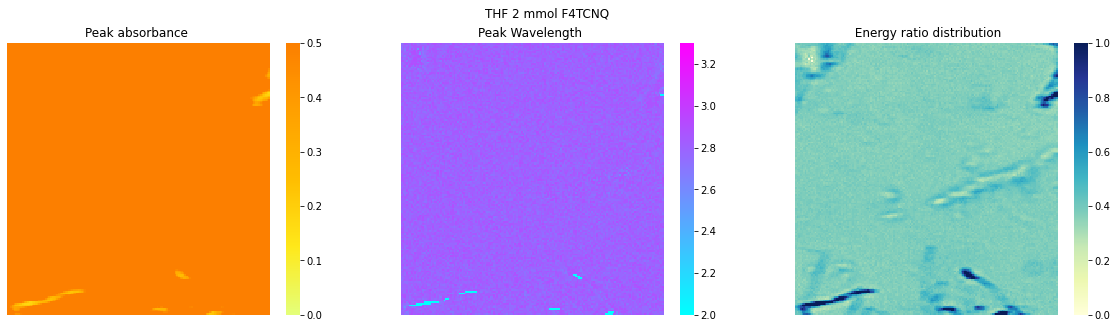

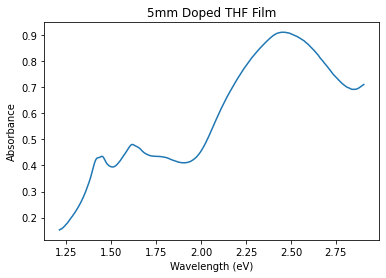

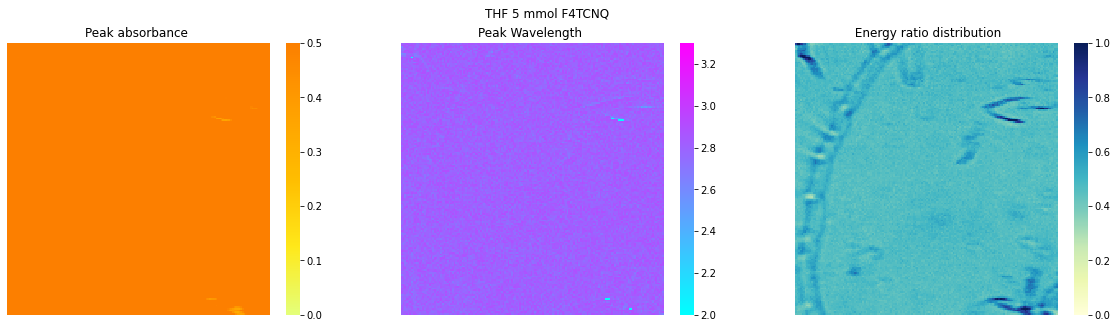

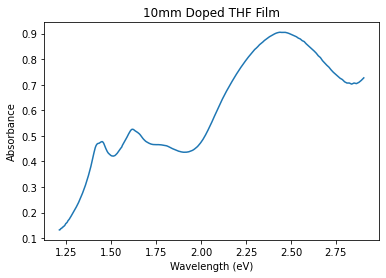

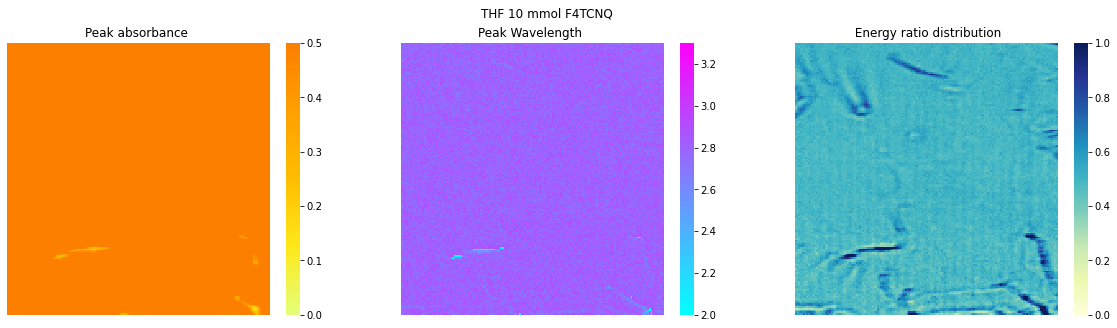

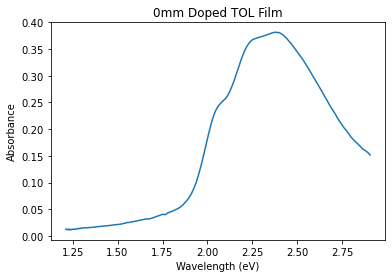

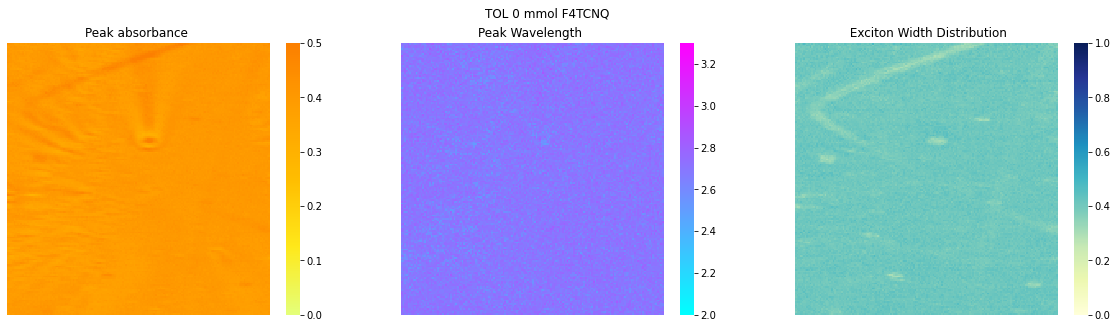

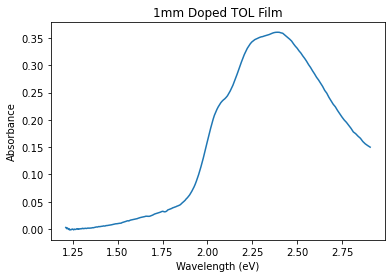

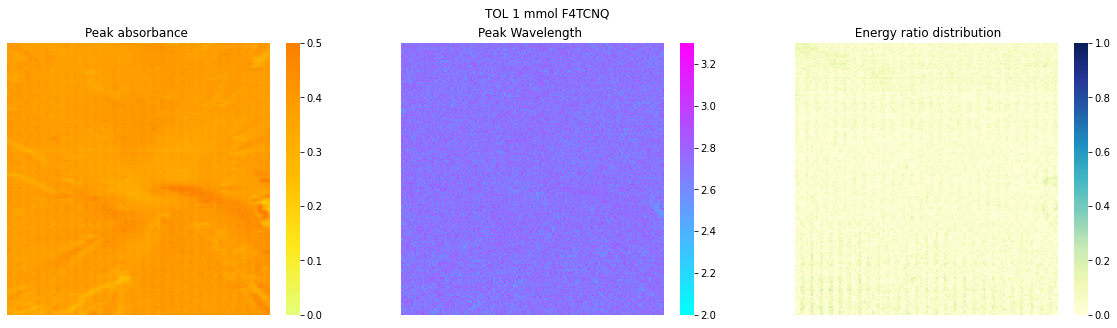

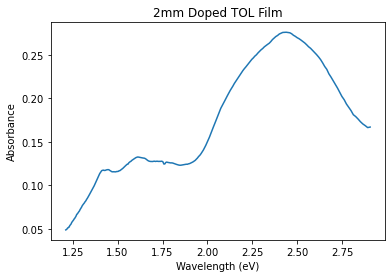

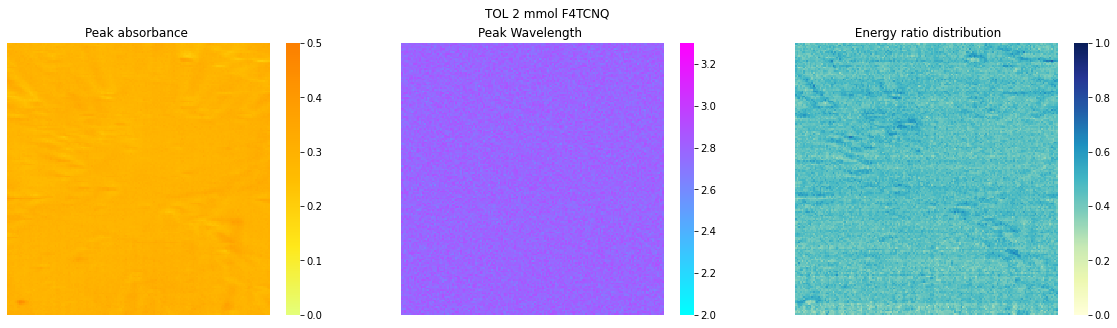

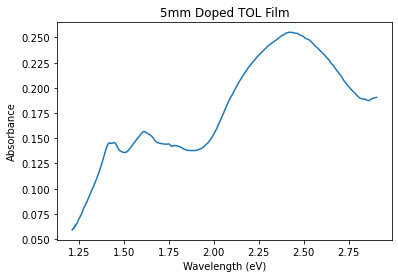

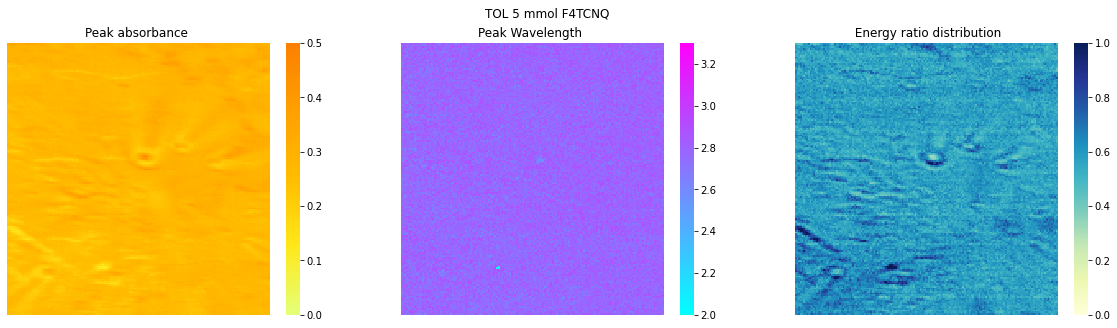

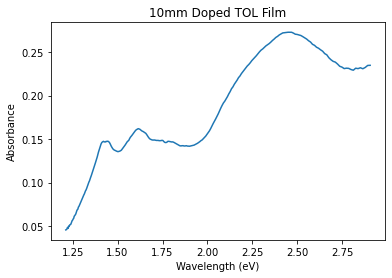

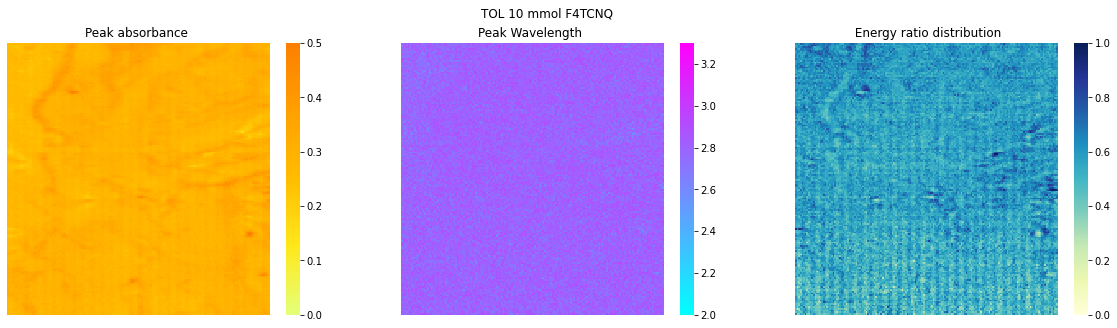

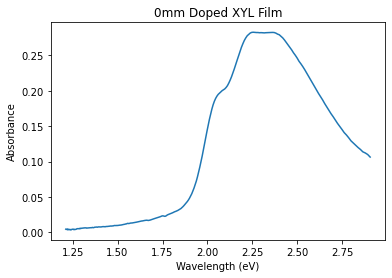

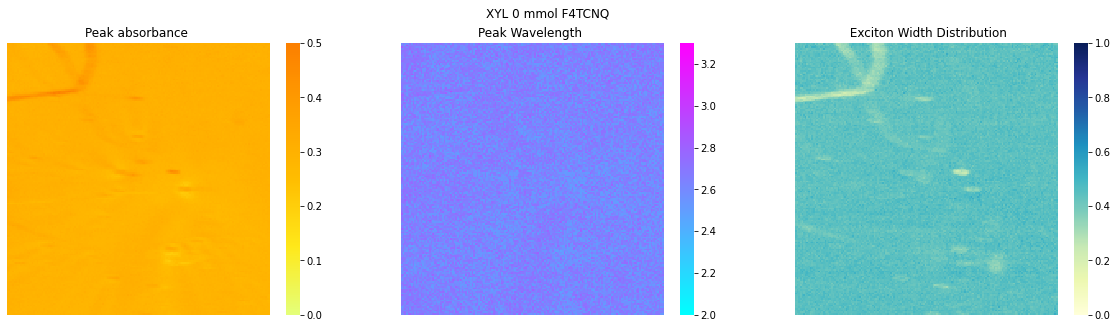

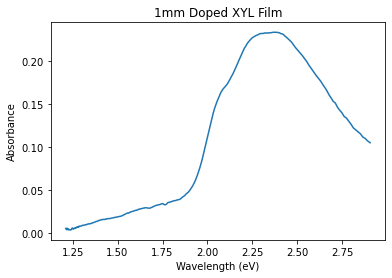

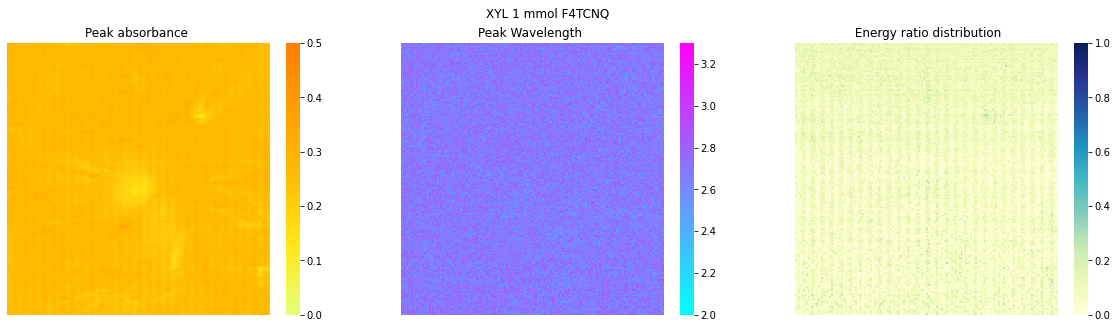

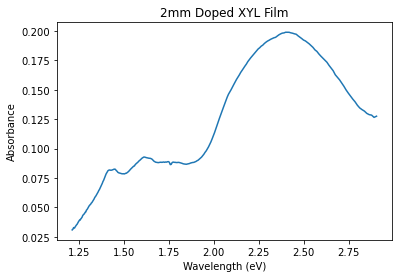

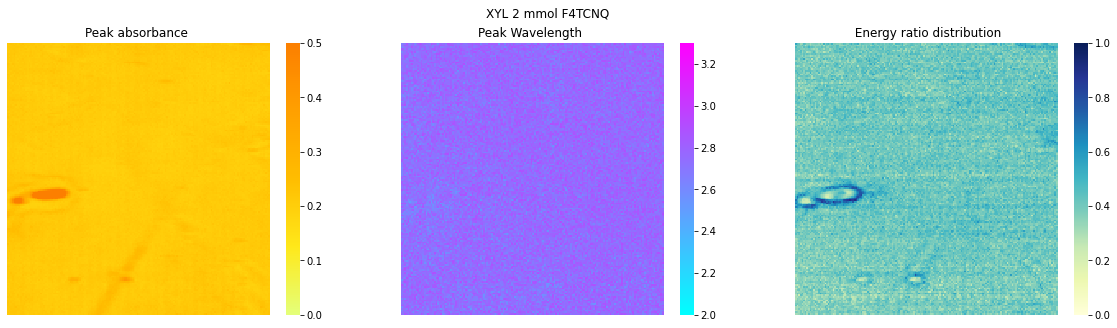

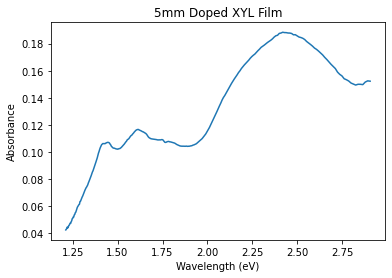

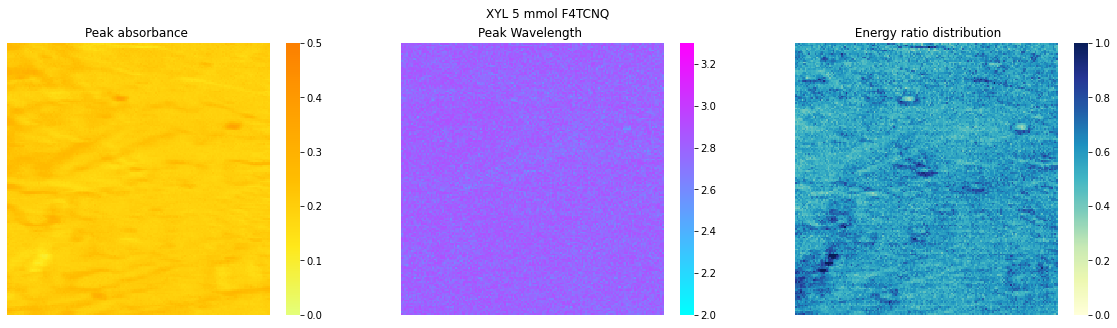

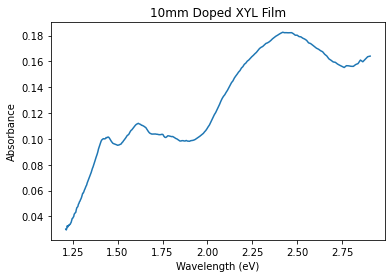

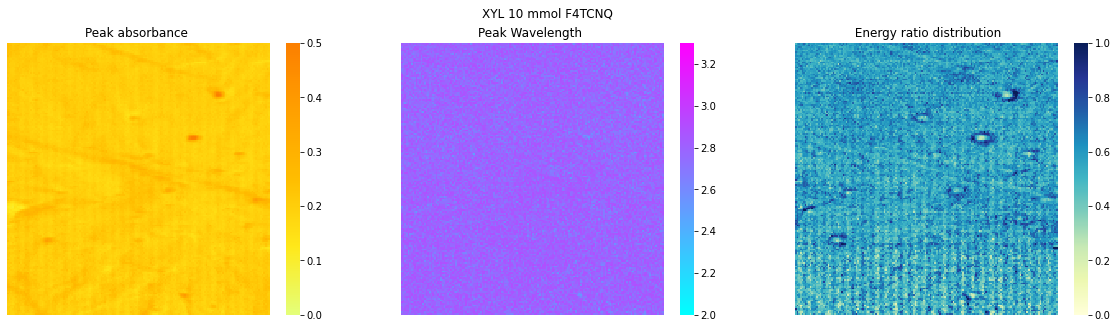

In [18]:
meane = {}
for k in c:
        dirName = "../results/"+k
        dirName2 = dirName+'/heatmaps'
        if not os.path.exists(dirName):
                os.mkdir(dirName)
        elif not os.path.exists(dirName2):
                os.mkdir(dirName2)


        f = [fn for fn in os.listdir(relevant_path+k+'/')
                if fn.endswith('.bil')]

        f.sort()
        #print(f)
        length = 160 # width and height
        intensity = 5 # bounding box line intensity
        line = 2 # bounding box line width
        coordinates =[(10,10)]
        for i in range(0,5):
                filename = f[i]
                label = labels[i]       
                arr=[]
                file = "../image/{}/{}".format(k,filename)
                arr = HSI.read_bil(file)
                bounding_boxed = arr
                rois = HSI.regions(coordinates,bounding_boxed,length,intensity, line)
                roimean = HSI.plotROI(rois,eV,label)
                roimean = roimean[20:]
                peakabs, peakenergy = HSI.peaks(roimean,bands)
                plt.figure()
                plt.plot(eV,roimean)         
                plt.title('{}mm Doped {} Film'.format(label,k))
                plt.xlabel('Wavelength (eV)')
                plt.ylabel('Absorbance')
                
                if i ==0 :
                        el = 86
                        abspeak, wavelengthpeaks,energy = HSI.peakabs(rois,eV,el)
                        abs = np.array(abspeak)
                        abs[abs==0] = np.mean(abs)
                        wave = np.array(wavelengthpeaks)
                        e = np.array(energy)
                        e = np.abs(e)
                        maintitle = k+' '+label+' mmol F4TCNQ'
                        width = np.zeros(shape = e.shape)
                        plt.plot()
                        for row in range(160):
                                for col in range(160):
                                        ratio = e[0][row][col]
                                        w = HSI.exciton_width(ratio)
                                        width[0][row][col] = w
                        
                        HSI.plotheatmap(abs,wave,width,maintitle,' Exciton Width Distribution')
                        meane[k] = np.mean(width)
                elif i>0:
                        el = 190
                        abspeak, wavelengthpeaks,energy = HSI.peakabs(rois,eV,el)
                        abs = np.array(abspeak)
                        abs[abs==0] = np.mean(abs)
                        wave = np.array(wavelengthpeaks)
                        maintitle = k+' '+label+' mmol F4TCNQ'
                        e = np.array(energy)
                        e = np.abs(e)
                        
                        HSI.plotheatmap(abs,wave,e,maintitle,' Energy ratio distribution')